In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import beta

from google.colab import files
uploaded = files.upload()

Saving 202501_clean2.xlsx to 202501_clean2.xlsx


In [17]:
# 1) BetaPERT 커스텀 정의
# =========================
class BetaPERT:
    def __init__(self, a, m, b, lamb=4):
        self.a = a  # 최소값
        self.m = m  # 최빈값(또는 중앙값 근사)
        self.b = b  # 최대값
        self.lamb = lamb  # 곡선 조정 파라미터 (기본 4)

        self.alpha = 1 + self.lamb * ((self.m - self.a) / (self.b - self.a))
        self.beta = 1 + self.lamb * ((self.b - self.m) / (self.b - self.a))

    def pdf(self, x):
        return beta.pdf((x - self.a) / (self.b - self.a),
                        self.alpha, self.beta) / (self.b - self.a)

    def cdf(self, x):
        return beta.cdf((x - self.a) / (self.b - self.a),
                        self.alpha, self.beta)

    def fit(self, data):
        a, m, b = np.min(data), np.median(data), np.max(data)
        return (a, m, b, self.lamb)

In [19]:
# 2) 분석 준비
# =========================
# 데이터 불러오기 (경로 수정)
df = pd.read_excel("/content/202501_clean2.xlsx")

# 금속 리스트
metals = ["Cr(ng/m3)", "Co(ng/m3)", "Ni(ng/m3)", "As(ng/m3)", "Cd(ng/m3)", "Sb(ng/m3)", "Pb(ng/m3)"]

# 후보 분포 (14종)
dist_list = [
    "norm", "lognorm", "weibull_min", "logistic", "t", "gamma", "beta",
    "triang", "gumbel_r", "gumbel_l", "expon", "pareto", "uniform", "BetaPERT"
]

In [20]:
# 3) 분포 적합도 계산 함수
# =========================
def fit_distributions(data, metal_name):
    results = []
    data = data[~np.isnan(data)]

    for dist_name in dist_list:
        try:
            if dist_name == "BetaPERT":
                # BetaPERT 전용 fitting
                a, m, b, lamb = BetaPERT(0,0,0).fit(data)
                pert = BetaPERT(a, m, b, lamb)

                # K-S test
                ks_stat, ks_p = stats.kstest(data, lambda x: pert.cdf(x))

                results.append({
                    "Metal": metal_name,
                    "Dist": dist_name,
                    "A-D": None,
                    "A-D P": None,
                    "K-S": ks_stat,
                    "K-S P": ks_p,
                    "Chi2": None,
                    "Chi2 P": None,
                    "Params": (a, m, b, lamb)
                })

            else:
                dist = getattr(stats, dist_name)
                params = dist.fit(data)

                # K-S
                ks_stat, ks_p = stats.kstest(data, dist_name, args=params)

                # Chi-square
                hist_obs, bin_edges = np.histogram(data, bins="auto")
                cdf = dist.cdf(bin_edges, *params)
                expected = len(data) * np.diff(cdf)
                chi_stat = ((hist_obs - expected) ** 2 / expected).sum()
                chi_p = 1 - stats.chi2.cdf(chi_stat, df=len(hist_obs)-len(params)-1)

                results.append({
                    "Metal": metal_name,
                    "Dist": dist_name,
                    "A-D": None,     # 필요시 anderson test 확장 가능
                    "A-D P": None,
                    "K-S": ks_stat,
                    "K-S P": ks_p,
                    "Chi2": chi_stat,
                    "Chi2 P": chi_p,
                    "Params": params
                })
        except Exception as e:
            print(f"{metal_name} - {dist_name} fitting error: {e}")

    return pd.DataFrame(results)

In [25]:
# 4) 히스토그램 + 피팅
# =========================
def plot_hist_with_fit(data, metal_name, best_dist, best_params):
    plt.figure(figsize=(6,5))

    # 데이터가 부족하거나, 분산이 거의 없는 경우 → 바로 메시지 박스 출력
    if len(data) < 10 or np.std(data) < 1e-6:
        plt.annotate(f"{metal_name}\nNo meaningful data",
                     xy=(0.5, 0.5), xycoords="axes fraction",
                     ha="center", va="center", fontsize=12,
                     bbox=dict(boxstyle="round", fc="lightgrey", ec="black"))
        plt.axis("off")
        plt.show()
        return

    # 히스토그램
    plt.hist(data, bins=40, density=True, alpha=0.6,
             color="steelblue", edgecolor="black")

    x = np.linspace(min(data), max(data), 200)

    try:
        if best_dist == "BetaPERT":
            a, m, b, lamb = best_params
            pert = BetaPERT(a, m, b, lamb)
            pdf = pert.pdf(x)
            if np.any(np.isnan(pdf)) or np.max(pdf) > 1e6:
                raise ValueError("BetaPERT invalid")
            plt.plot(x, pdf, "r-", lw=2, label="BetaPERT")

        else:
            dist = getattr(stats, best_dist)
            pdf = dist.pdf(x, *best_params)
            if np.any(np.isnan(pdf)) or np.max(pdf) > 1e6:
                raise ValueError("Distribution invalid")
            plt.plot(x, pdf, "r-", lw=2, label=best_dist)

        plt.title(f"{metal_name} Histogram + Best Fit ({best_dist})")
        plt.xlabel("Concentration (ng/m³)")
        plt.ylabel("Density")
        plt.legend()
    except:
        plt.annotate(f"{metal_name}\nNo meaningful data",
                     xy=(0.5, 0.5), xycoords="axes fraction",
                     ha="center", va="center", fontsize=12,
                     bbox=dict(boxstyle="round", fc="lightgrey", ec="black"))
        plt.axis("off")

    plt.show()

Cr(ng/m3) - BetaPERT fitting error: division by zero


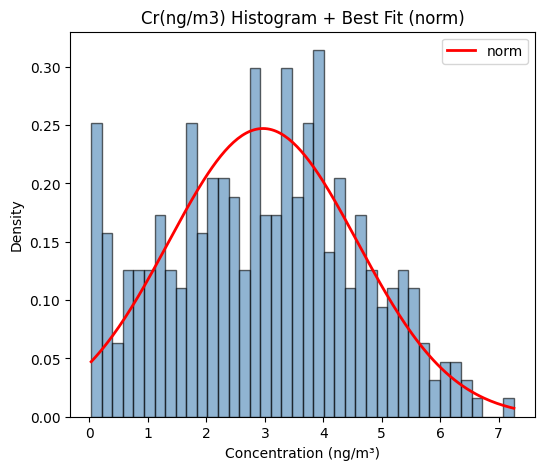

Co(ng/m3) - BetaPERT fitting error: division by zero


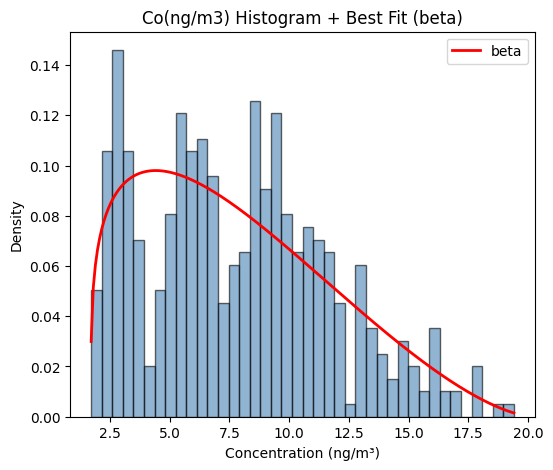

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:6930: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


Ni(ng/m3) - BetaPERT fitting error: division by zero


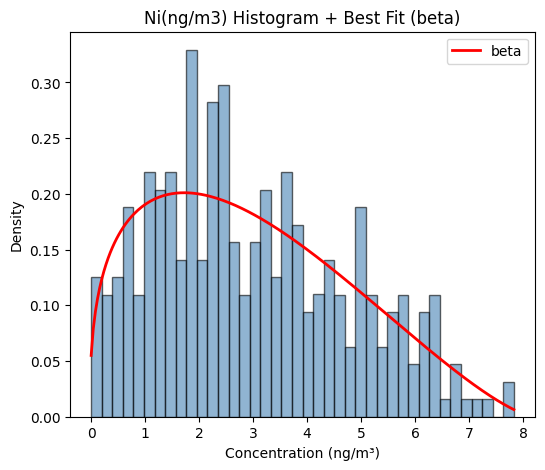

/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2148: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2148: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:6930: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:418: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:427: RuntimeWarning: invalid value encountered in scalar divide
  return m4 / m2**2 - 3
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iterat

As(ng/m3) - gamma fitting error: Optimization converged to parameters that are outside the range allowed by the distribution.
As(ng/m3) - gumbel_r fitting error: int too large to convert to float
As(ng/m3) - gumbel_l fitting error: int too large to convert to float
As(ng/m3) - BetaPERT fitting error: division by zero


/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:8244: RuntimeWarning: divide by zero encountered in scalar divide
  return ndata / np.sum(np.log((data - location) / scale))
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:8267: RuntimeWarning: invalid value encountered in scalar subtract
  return dL_dLocation(shape, location) - dL_dScale(shape, scale)


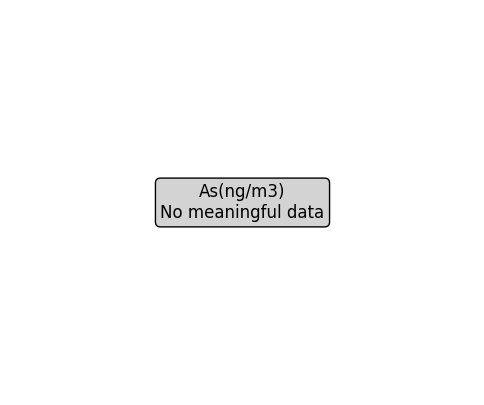

Cd(ng/m3) - BetaPERT fitting error: division by zero


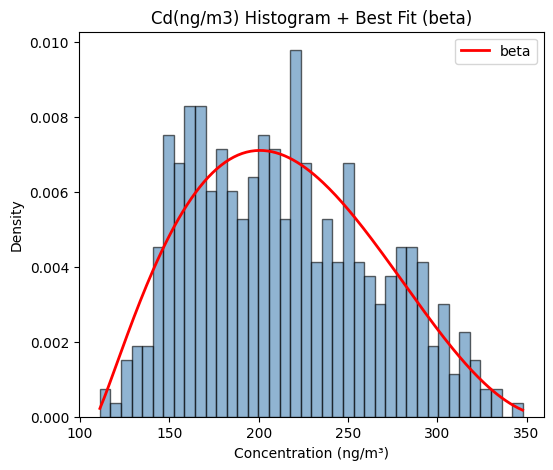

Sb(ng/m3) - BetaPERT fitting error: division by zero


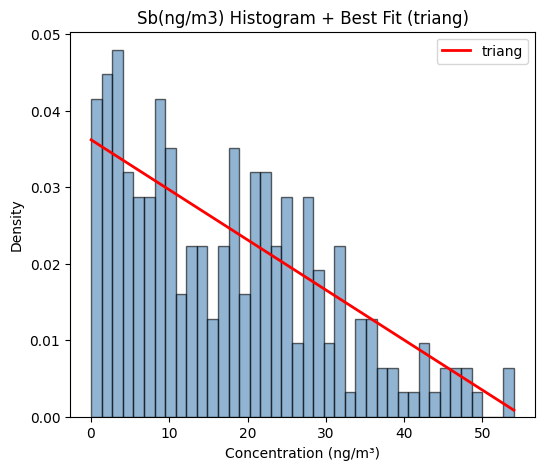

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Pb(ng/m3) - BetaPERT fitting error: division by zero


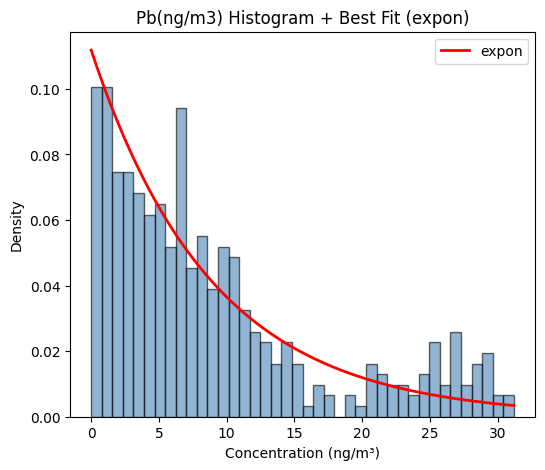

,Metal,Dist,A-D,A-D P,K-S,K-S P,Chi2,Chi2 P,Params
0,Cr(ng/m3),norm,None,None,0.037302,6.970342e-01,26.451219,8.789017e-04,"(2.9691193181818183, 1.614625472851631)"
6,Co(ng/m3),beta,None,None,0.053718,1.444704e-01,22.917071,3.472365e-03,"(1.2699765599677932, 2.572594643100623, 1.6966..."
6,Ni(ng/m3),beta,None,None,0.032965,8.587917e-01,3.667408,7.215798e-01,"(1.3788877904279768, 2.4059804825110414, -0.02..."
5,As(ng/m3),beta,None,None,0.612215,3.059701e-162,0.000000,NaN,"(0.9722990882431171, 1.0503879864987535, -9.25..."
6,Cd(ng/m3),beta,None,None,0.033860,6.690238e-01,16.056672,2.460361e-02,"(2.2005261490097463, 3.1427414398791207, 108.7..."
7,Sb(ng/m3),triang,None,None,0.056614,4.309809e-01,8.161056,1.475800e-01,"(1.9494740770909142e-11, 0.039999998347633986,..."
10,Pb(ng/m3),expon,None,None,0.042939,4.477785e-01,71.503097,6.321610e-11,"(0.0, 8.93979746835443)"


In [26]:
# 5) 전체 실행
# =========================
summary_list = []

for metal in metals:
    data = df[metal].dropna().values
    res = fit_distributions(data, metal)

    # 최적 분포 선택 (우선: K-S P값 기준)
    best_row = res.sort_values(by=["K-S P"], ascending=False).iloc[0]
    summary_list.append(best_row)

    # 히스토그램 + 최적 분포 피팅
    plot_hist_with_fit(data, metal, best_row["Dist"], best_row["Params"])

# 금속별 최적 분포 요약
summary_df = pd.DataFrame(summary_list)
summary_df

In [86]:
# ==== Colab: 1단계 적합도 표 생성 & 다운로드 (AIC/BIC 비활성) ====
from google.colab import files
uploaded = files.upload()  # '202501_clean2.xlsx'와 (선택) 'Tx-적합도 보고서.xlsx' 업로드

# 파일 경로 설정
import os
DATA_PATH = '202501_clean2.xlsx' if '202501_clean2.xlsx' in uploaded else \
            next((k for k in uploaded if k.lower().endswith('.xlsx')), None)
TEMPLATE_PATH = 'Tx-적합도 보고서.xlsx' if 'Tx-적합도 보고서.xlsx' in uploaded else None
OUTPUT_PATH = 'Tx-적합도.xlsx'

Saving 202501_clean2.xlsx to 202501_clean2 (8).xlsx
Saving Tx-적합도 보고서.xlsx to Tx-적합도 보고서 (4).xlsx


In [87]:
import numpy as np, pandas as pd, json, re
from scipy import stats
from scipy.stats import (gumbel_r, gumbel_l, lognorm, weibull_min, logistic, t,
                         norm, gamma, beta, triang, expon, pareto, uniform, chi2)
from openpyxl import load_workbook, Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.utils import get_column_letter

np.random.seed(42)
BOOTSTRAP_B = 300  # A-D p값 부트스트랩 수 (속도 필요시 120)

In [88]:
# ---- 유틸 ----
def detect_numeric_metal_columns(df):
    ex = {'date','time','pump','begin','start','end','id','index','sample','unit',
          'yyyymm','yyyy','mm','dd','hour','minute','sec'}
    num = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    return [c for c in num if not any(k in str(c).lower() for k in ex)]

def to_numpy_clean(x): return pd.Series(x).dropna().astype(float).values

def hist_mode_estimate(x):
    x = np.asarray(x); n=len(x)
    if n<2: return float(np.median(x))
    iqr = np.subtract(*np.percentile(x,[75,25]));
    bins = int(np.ceil(np.sqrt(n))) if iqr<=0 else max(10, int(np.ceil((x.max()-x.min())/(2*iqr*n**(-1/3)))))
    cnt,edges=np.histogram(x,bins=bins); i=cnt.argmax()
    return float((edges[i]+edges[i+1])/2)

In [89]:
# ---- 분포 래퍼 ----
class W:
    def __init__(self,name,pos=False): self.name=name; self.pos=pos; self.params={}; self.np=None; self.valid=True
    def _fail(self,msg): self.valid=False; self.params['error']=msg

class GumbelR(W):
    def __init__(self): super().__init__('최대극값')
    def fit(self,x):
        try: loc,scale=gumbel_r.fit(x); assert np.isfinite(loc) and scale>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(loc=loc,scale=scale); self.np=2; return self
    def pdf(self,z): return gumbel_r.pdf(z,**self.params)
    def cdf(self,z): return gumbel_r.cdf(z,**self.params)
    def ppf(self,q): return gumbel_r.ppf(q,**self.params)
    def rvs(self,n): return gumbel_r.rvs(size=n,**self.params, random_state=42)

class LogNormal(W):
    def __init__(self): super().__init__('로그 정규',True)
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail('insufficient') or self
        try: s,loc,sc=lognorm.fit(x,floc=0); assert s>0 and sc>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(shape=s,loc=0.0,scale=sc); self.np=2; return self
    def pdf(self,z): return lognorm.pdf(z,s=self.params['shape'],loc=0,scale=self.params['scale'])
    def cdf(self,z): return lognorm.cdf(z,s=self.params['shape'],loc=0,scale=self.params['scale'])
    def ppf(self,q): return lognorm.ppf(q,s=self.params['shape'],loc=0,scale=self.params['scale'])
    def rvs(self,n): return lognorm.rvs(s=self.params['shape'],loc=0,scale=self.params['scale'],size=n, random_state=42)

class Weibull(W):
    def __init__(self): super().__init__('와이블',True)
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail('insufficient') or self
        try: c,loc,sc=weibull_min.fit(x,floc=0); assert c>0 and sc>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(c=c,loc=0.0,scale=sc); self.np=2; return self
    def pdf(self,z): return weibull_min.pdf(z,c=self.params['c'],loc=0,scale=self.params['scale'])
    def cdf(self,z): return weibull_min.cdf(z,c=self.params['c'],loc=0,scale=self.params['scale'])
    def ppf(self,q): return weibull_min.ppf(q,c=self.params['c'],loc=0,scale=self.params['scale'])
    def rvs(self,n): return weibull_min.rvs(c=self.params['c'],loc=0,scale=self.params['scale'],size=n, random_state=42)

class Logistic(W):
    def __init__(self): super().__init__('로지스틱')
    def fit(self,x):
        try: loc,sc=logistic.fit(x); assert sc>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(loc=loc,scale=sc); self.np=2; return self
    def pdf(self,z): return logistic.pdf(z,**self.params)
    def cdf(self,z): return logistic.cdf(z,**self.params)
    def ppf(self,q): return logistic.ppf(q,**self.params)
    def rvs(self,n): return logistic.rvs(size=n,**self.params, random_state=42)

class StudentT(W):
    def __init__(self): super().__init__('스튜던트의 t')
    def fit(self,x):
        try: df_,loc,sc=t.fit(x); assert df_>0 and sc>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(df=df_,loc=loc,scale=sc); self.np=3; return self
    def pdf(self,z): return t.pdf(z,**self.params)
    def cdf(self,z): return t.cdf(z,**self.params)
    def ppf(self,q): return t.ppf(q,**self.params)
    def rvs(self,n): return t.rvs(size=n,**self.params, random_state=42)

class Normal(W):
    def __init__(self): super().__init__('정규')
    def fit(self,x):
        try: mu,sig=norm.fit(x); assert sig>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(loc=mu,scale=sig); self.np=2; return self
    def pdf(self,z): return norm.pdf(z,**self.params)
    def cdf(self,z): return norm.cdf(z,**self.params)
    def ppf(self,q): return norm.ppf(q,**self.params)
    def rvs(self,n): return norm.rvs(size=n,**self.params, random_state=42)

class Gamma_(W):
    def __init__(self): super().__init__('감마',True)
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail('insufficient') or self
        try: a,loc,sc=gamma.fit(x,floc=0); assert a>0 and sc>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(a=a,loc=0.0,scale=sc); self.np=2; return self
    def pdf(self,z): return gamma.pdf(z,a=self.params['a'],loc=0,scale=self.params['scale'])
    def cdf(self,z): return gamma.cdf(z,a=self.params['a'],loc=0,scale=self.params['scale'])
    def ppf(self,q): return gamma.ppf(q,a=self.params['a'],loc=0,scale=self.params['scale'])
    def rvs(self,n): return gamma.rvs(a=self.params['a'],loc=0,scale=self.params['scale'],size=n, random_state=42)

class Beta_(W):
    def __init__(self): super().__init__('베타')
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not (np.isfinite(a) and np.isfinite(b) and b>a): return self._fail('support') or self
        z=np.clip((x-a)/(b-a),1e-9,1-1e-9)
        try: al,be,_,_=beta.fit(z,floc=0,fscale=1); assert al>0 and be>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(alpha=al,beta=be,a=a,b=b); self.np=2; return self
    def _z(self,z): return (z-self.params['a'])/(self.params['b']-self.params['a'])
    def pdf(self,z): return beta.pdf(self._z(z),self.params['alpha'],self.params['beta'])/(self.params['b']-self.params['a'])
    def cdf(self,z): return beta.cdf(self._z(z),self.params['alpha'],self.params['beta'])
    def ppf(self,q): return self.params['a']+(self.params['b']-self.params['a'])*beta.ppf(q,self.params['alpha'],self.params['beta'])
    def rvs(self,n):
        r=beta.rvs(self.params['alpha'],self.params['beta'],size=n,random_state=42)
        return self.params['a']+(self.params['b']-self.params['a'])*r

class Triangular_(W):
    def __init__(self): super().__init__('삼각형')
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not (np.isfinite(a) and np.isfinite(b) and b>a): return self._fail('support') or self
        m=float(np.clip(hist_mode_estimate(x),a+1e-9,b-1e-9)); c=(m-a)/(b-a)
        if not (0<c<1): return self._fail('c') or self
        self.params.update(a=a,m=m,b=b,c=c); self.np=3; return self
    def pdf(self,z): return triang.pdf(z,c=self.params['c'],loc=self.params['a'],scale=(self.params['b']-self.params['a']))
    def cdf(self,z): return triang.cdf(z,c=self.params['c'],loc=self.params['a'],scale=(self.params['b']-self.params['a']))
    def ppf(self,q): return triang.ppf(q,c=self.params['c'],loc=self.params['a'],scale=(self.params['b']-self.params['a']))
    def rvs(self,n): return triang.rvs(c=self.params['c'],loc=self.params['a'],scale=(self.params['b']-self.params['a']),size=n,random_state=42)

class GumbelL(W):
    def __init__(self): super().__init__('최소극값')
    def fit(self,x):
        try: loc,sc=gumbel_l.fit(x); assert sc>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(loc=loc,scale=sc); self.np=2; return self
    def pdf(self,z): return gumbel_l.pdf(z,**self.params)
    def cdf(self,z): return gumbel_l.cdf(z,**self.params)
    def ppf(self,q): return gumbel_l.ppf(q,**self.params)
    def rvs(self,n): return gumbel_l.rvs(size=n,**self.params, random_state=42)

class Exponential_(W):
    def __init__(self): super().__init__('지수',True)
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail('insufficient') or self
        try: loc,sc=expon.fit(x,floc=0); assert sc>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(loc=0.0,scale=sc); self.np=1; return self
    def pdf(self,z): return expon.pdf(z,**self.params)
    def cdf(self,z): return expon.cdf(z,**self.params)
    def ppf(self,q): return expon.ppf(q,**self.params)
    def rvs(self,n): return expon.rvs(size=n,**self.params, random_state=42)

class Pareto_(W):
    def __init__(self): super().__init__('파레토',True)
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail('insufficient') or self
        try: b,loc,sc=pareto.fit(x,floc=0); assert b>0 and sc>0
        except Exception as e: return self._fail(str(e)) or self
        self.params.update(b=b,loc=0.0,scale=sc); self.np=2; return self
    def pdf(self,z): return pareto.pdf(z,**self.params)
    def cdf(self,z): return pareto.cdf(z,**self.params)
    def ppf(self,q): return pareto.ppf(q,**self.params)
    def rvs(self,n): return pareto.rvs(self.params['b'],loc=0,scale=self.params['scale'],size=n,random_state=42)

class BetaPERT_(W):
    def __init__(self,lam=4.0): super().__init__('BetaPERT'); self.lam=lam
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not (np.isfinite(a) and np.isfinite(b) and b>a): return self._fail('support') or self
        m=float(np.clip(hist_mode_estimate(x),a+1e-9,b-1e-9))
        al=1+self.lam*(m-a)/(b-a); be=1+self.lam*(b-m)/(b-a)
        if not (al>0 and be>0): return self._fail('alpha/beta') or self
        self.params.update(alpha=al,beta=be,a=a,b=b,m=m,lam=self.lam); self.np=2; return self
    def _z(self,z): return (z-self.params['a'])/(self.params['b']-self.params['a'])
    def pdf(self,z): return beta.pdf(self._z(z),self.params['alpha'],self.params['beta'])/(self.params['b']-self.params['a'])
    def cdf(self,z): return beta.cdf(self._z(z),self.params['alpha'],self.params['beta'])
    def ppf(self,q): return self.params['a']+(self.params['b']-self.params['a'])*beta.ppf(q,self.params['alpha'],self.params['beta'])
    def rvs(self,n):
        r=beta.rvs(self.params['alpha'],self.params['beta'],size=n,random_state=42)
        return self.params['a']+(self.params['b']-self.params['a'])*r

class Uniform_(W):
    def __init__(self): super().__init__('균일')
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not (np.isfinite(a) and np.isfinite(b) and b>a): return self._fail('support') or self
        self.params.update(loc=a,scale=(b-a)); self.np=2; return self
    def pdf(self,z): return uniform.pdf(z,**self.params)
    def cdf(self,z): return uniform.cdf(z,**self.params)
    def ppf(self,q): return uniform.ppf(q,**self.params)
    def rvs(self,n): return uniform.rvs(size=n,**self.params, random_state=42)

def dists():
    return [GumbelR(), LogNormal(), Weibull(), Logistic(), StudentT(), Normal(),
            Gamma_(), Beta_(), Triangular_(), GumbelL(), Exponential_(),
            Pareto_(), BetaPERT_(), Uniform_()]

In [90]:
# ---- 지표 ----
def AD_stat(x, cdf, eps=1e-12):
    x=np.sort(x); n=len(x)
    u=np.clip(cdf(x),eps,1-eps); i=np.arange(1,n+1)
    return float(-n - np.sum((2*i-1)*(np.log(u)+np.log(1-u[::-1])))/n)

def AD_p_boot(x, dist, A2, B=300):
    n=len(x);
    if n<5 or not dist.valid: return np.nan
    cnt=0
    for _ in range(B):
        xs=dist.rvs(n); A2s=AD_stat(xs, dist.cdf)
        if A2s>=A2: cnt+=1
    return float(cnt/B)

def KS_stat_p(x, dist):
    try: D,p=stats.kstest(x, lambda z: dist.cdf(z)); return float(D),float(p)
    except Exception: return np.nan, np.nan

def Chi2_stat_p(x, dist):
    try:
        n=len(x); N=max(5,min(50,n//5)); eps=1e-6
        qs=np.linspace(eps,1-eps,N+1); edges=np.unique(dist.ppf(qs))
        if len(edges)<3: return np.nan, np.nan
        obs,_=np.histogram(x,bins=edges); exp=np.diff(qs)*n
        k=dist.np or 0; df=len(obs)-1-k
        if df<=0: return np.nan, np.nan
        exp=np.maximum(exp[:len(obs)],1e-9)
        chi_val=np.sum((obs-exp)**2/exp); p=1.0-chi2.cdf(chi_val,df)
        return float(chi_val), float(p)
    except Exception: return np.nan, np.nan

def param_str(name,p):
    try:
        if name=='로그 정규': return f"shape={p['shape']:.4g}, scale={p['scale']:.4g}, loc=0"
        if name=='와이블':   return f"c={p['c']:.4g}, scale={p['scale']:.4g}, loc=0"
        if name=='감마':     return f"a={p['a']:.4g}, scale={p['scale']:.4g}, loc=0"
        if name=='지수':     return f"scale={p['scale']:.4g}, loc=0"
        if name in ['최대극값','최소극값','정규','로지스틱']: return f"loc={p['loc']:.4g}, scale={p['scale']:.4g}"
        if name=='스튜던트의 t': return f"df={p['df']:.4g}, loc={p['loc']:.4g}, scale={p['scale']:.4g}"
        if name=='파레토':  return f"b={p['b']:.4g}, scale={p['scale']:.4g}, loc=0"
        if name=='베타':     return f"alpha={p['alpha']:.4g}, beta={p['beta']:.4g}, a={p['a']:.4g}, b={p['b']:.4g}"
        if name=='BetaPERT': return f"alpha={p['alpha']:.4g}, beta={p['beta']:.4g}, a={p['a']:.4g}, m={p['m']:.4g}, b={p['b']:.4g}, λ={p.get('lam',4)}"
        if name=='삼각형':   return f"a={p['a']:.4g}, m={p['m']:.4g}, b={p['b']:.4g}"
        if name=='균일':     return f"min={p['loc']:.4g}, max={(p['loc']+p['scale']):.4g}"
        return json.dumps(p, ensure_ascii=False)
    except Exception: return json.dumps(p, ensure_ascii=False)

POSITIVE = {'로그 정규','와이블','감마','지수','파레토'}

def fit_one_col(x_raw):
    x = to_numpy_clean(x_raw)
    if len(x)<20:
        return pd.DataFrame(columns=['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수',
                                     '_AD','_KS_p','_Chi2_p','_n_params'])
    rows=[]
    for d in dists():
        d=d.fit(x)
        if not d or not d.valid:
            rows.append({'분포':d.name,'A-D':np.nan,'A-D P-값':np.nan,'K-S':np.nan,'K-S P-값':np.nan,
                         '카이제곱':np.nan,'카이제곱 P-값':np.nan,'매개 변수':param_str(d.name,d.params),
                         '_AD':np.inf,'_KS_p':-np.inf,'_Chi2_p':-np.inf,'_n_params':1e9})
            continue
        xe = x[x>0] if d.name in POSITIVE else x
        if len(xe)<5:
            rows.append({'분포':d.name,'A-D':np.nan,'A-D P-값':np.nan,'K-S':np.nan,'K-S P-값':np.nan,
                         '카이제곱':np.nan,'카이제곱 P-값':np.nan,'매개 변수':param_str(d.name,d.params),
                         '_AD':np.inf,'_KS_p':-np.inf,'_Chi2_p':-np.inf,'_n_params':d.np or 1e9})
            continue
        A2=AD_stat(xe,d.cdf); pAD=AD_p_boot(xe,d,A2,B=BOOTSTRAP_B)
        D,pKS=KS_stat_p(xe,d); chi,pCHI=Chi2_stat_p(xe,d)
        rows.append({'분포':d.name,'A-D':A2,'A-D P-값':pAD,'K-S':D,'K-S P-값':pKS,
                     '카이제곱':chi,'카이제곱 P-값':pCHI,'매개 변수':param_str(d.name,d.params),
                     '_AD':A2,'_KS_p':pKS,'_Chi2_p':pCHI,'_n_params':d.np or 1e9})
    df=pd.DataFrame(rows)
    df['_key']=list(zip(
        df['_AD'].apply(lambda v: v if np.isfinite(v) else np.inf),
        df['_KS_p'].apply(lambda v: -v if np.isfinite(v) else np.inf),
        df['_Chi2_p'].apply(lambda v: -v if np.isfinite(v) else np.inf),
        df['_n_params'].apply(lambda v: v if np.isfinite(v) else np.inf)
    ))
    return df.sort_values('_key',kind='mergesort').drop(columns=['_key']).reset_index(drop=True)


In [91]:
# ---- 엑셀 쓰기 ----
def safe_title(wb, name):
    t=re.sub(r'[:\\/?*\[\]]','_',str(name)).strip("' ").strip() or 'Sheet'
    t=t[:31]; base=t; k=1
    while t in wb.sheetnames:
        suf=f"_{k}"; t=base[:31-len(suf)]+suf; k+=1
    return t

def apply_header(ws, headers, template_ws=None):
    # 헤더 스타일(단순화: 굵게/가운데/연한 노랑, 테두리)
    thin=Side(style='thin', color='999999'); border=Border(top=thin,bottom=thin,left=thin,right=thin)
    for j,h in enumerate(headers,1):
        c=ws.cell(row=1,column=j,value=h)
        c.font=Font(bold=True); c.alignment=Alignment(horizontal='center',vertical='center',wrap_text=True)
        c.fill=PatternFill('solid', fgColor='FFF2CC'); c.border=border
        # 열 너비: 템플릿 있으면 복제, 없으면 기본폭
        col=get_column_letter(j)
        if template_ws and template_ws.column_dimensions.get(col) and template_ws.column_dimensions[col].width:
            ws.column_dimensions[col].width = template_ws.column_dimensions[col].width
        else:
            ws.column_dimensions[col].width = max(12, len(str(h))+2)

def write_table_sheet(wb, name, df, template_ws=None):
    ws=wb.create_sheet(title=safe_title(wb,name))
    headers=['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수']
    apply_header(ws, headers, template_ws)
    for i,row in df.iterrows():
        ws.cell(row=i+2,column=1,value=row['분포'])
        ws.cell(row=i+2,column=2,value=None if pd.isna(row['A-D']) else float(row['A-D']))
        ws.cell(row=i+2,column=3,value=None if pd.isna(row['A-D P-값']) else float(row['A-D P-값']))
        ws.cell(row=i+2,column=4,value=None if pd.isna(row['K-S']) else float(row['K-S']))
        ws.cell(row=i+2,column=5,value=None if pd.isna(row['K-S P-값']) else float(row['K-S P-값']))
        ws.cell(row=i+2,column=6,value=None if pd.isna(row['카이제곱']) else float(row['카이제곱']))
        ws.cell(row=i+2,column=7,value=None if pd.isna(row['카이제곱 P-값']) else float(row['카이제곱 P-값']))
        ws.cell(row=i+2,column=8,value=row['매개 변수'])
    # 최적(1행) 강조
    for c in range(1,9):
        cell=ws.cell(row=2,column=c)
        cell.font=Font(bold=True)
        cell.fill=PatternFill('solid', fgColor='FFF2CC')

def write_summary(wb, results, template_ws=None):
    ws=wb.create_sheet(title='Summary_Top1')
    headers=['금속','최적 분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수']
    apply_header(ws, headers, template_ws)
    r=2
    for metal,df in results.items():
        if df.empty: continue
        b=df.iloc[0]
        vals=[metal,b['분포'],b['A-D'],b['A-D P-값'],b['K-S'],b['K-S P-값'],b['카이제곱'],b['카이제곱 P-값'],b['매개 변수']]
        for j,v in enumerate(vals,1):
            ws.cell(row=r,column=j,value=None if (isinstance(v,float) and (np.isnan(v) or np.isinf(v))) else (float(v) if isinstance(v,(np.floating,float)) else v))
            ws.cell(row=r,column=j).font=Font(bold=True)
        r+=1

In [92]:
# ---- 실행 ----
if DATA_PATH is None:
    raise ValueError('엑셀 데이터(.xlsx)를 업로드하세요 (예: 202501_clean2.xlsx).')

df = pd.read_excel(DATA_PATH)
metal_cols = detect_numeric_metal_columns(df)
if not metal_cols: raise ValueError('분석 대상 숫자형(금속) 컬럼이 없습니다.')

# 금속별 적합도 계산 & 정렬
results={}
for col in metal_cols:
    results[col]=fit_one_col(df[col].values)

# 템플릿 첫 시트(열 너비 복제용) 로드
tpl_ws = None
if TEMPLATE_PATH and os.path.exists(TEMPLATE_PATH):
    try: tpl_ws = load_workbook(TEMPLATE_PATH).worksheets[0]
    except Exception: tpl_ws = None

# 엑셀 생성
wb=Workbook(); wb.remove(wb.active)
for m,table in results.items(): write_table_sheet(wb, m, table, template_ws=tpl_ws)
write_summary(wb, results, template_ws=tpl_ws)
wb.save(OUTPUT_PATH)
print('Saved:', OUTPUT_PATH)

Saved: Tx-적합도.xlsx


In [93]:
# Colab 다운로드
files.download(OUTPUT_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
# === Colab: 1단계 · 한 시트 출력(스타일 포함) ===
from google.colab import files
uploaded = files.upload()  # '202501_clean2.xlsx' 업로드(필수). 템플릿은 불필요.

import numpy as np, pandas as pd, json, re, os
from scipy import stats
from scipy.stats import (gumbel_r, gumbel_l, lognorm, weibull_min, logistic, t,
                         norm, gamma, beta, triang, expon, pareto, uniform, chi2)
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.utils import get_column_letter

DATA_PATH = '202501_clean2.xlsx'
OUTPUT_PATH = 'Tx-적합도.xlsx'
np.random.seed(42); BOOTSTRAP_B = 300  # 속도 필요시 120

Saving 202501_clean2.xlsx to 202501_clean2 (9).xlsx
Saving Tx-적합도 보고서.xlsx to Tx-적합도 보고서 (5).xlsx


In [100]:
# ---------- 유틸 ----------
def detect_numeric_metal_columns(df):
    ex = {'date','time','pump','begin','start','end','id','index','sample','unit',
          'yyyymm','yyyy','mm','dd','hour','minute','sec'}
    num = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    return [c for c in num if not any(k in str(c).lower() for k in ex)]

def to_numpy_clean(x): return pd.Series(x).dropna().astype(float).values

def hist_mode_estimate(x):
    x = np.asarray(x); n=len(x)
    if n<2: return float(np.median(x))
    iqr = np.subtract(*np.percentile(x,[75,25]))
    bins = int(np.ceil(np.sqrt(n))) if iqr<=0 else max(10, int(np.ceil((x.max()-x.min())/(2*iqr*n**(-1/3)))))
    cnt,edges=np.histogram(x,bins=bins); i=cnt.argmax()
    return float((edges[i]+edges[i+1])/2)

# ---------- 분포 래퍼(간결) ----------
class W:
    def __init__(self,name): self.name=name; self.p={}; self.np=None; self.valid=True
    def _fail(self): self.valid=False; return self

class GumbelR(W):
    def __init__(self): super().__init__('최대 극값')
    def fit(self,x):
        try: loc,sc=gumbel_r.fit(x); assert np.isfinite(loc) and sc>0
        except: return self._fail()
        self.p=dict(loc=loc,scale=sc); self.np=2; return self
    def pdf(self,z): return gumbel_r.pdf(z,**self.p)
    def cdf(self,z): return gumbel_r.cdf(z,**self.p)
    def ppf(self,q): return gumbel_r.ppf(q,**self.p)
    def rvs(self,n): return gumbel_r.rvs(size=n,**self.p, random_state=42)

class LogNormal(W):
    def __init__(self): super().__init__('로그 정규')
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail()
        try: s,loc,sc=lognorm.fit(x,floc=0); assert s>0 and sc>0
        except: return self._fail()
        self.p=dict(shape=s,loc=0.0,scale=sc); self.np=2; return self
    def pdf(self,z): return lognorm.pdf(z,s=self.p['shape'],loc=0,scale=self.p['scale'])
    def cdf(self,z): return lognorm.cdf(z,s=self.p['shape'],loc=0,scale=self.p['scale'])
    def ppf(self,q): return lognorm.ppf(q,s=self.p['shape'],loc=0,scale=self.p['scale'])
    def rvs(self,n): return lognorm.rvs(s=self.p['shape'],loc=0,scale=self.p['scale'],size=n, random_state=42)

class Weibull(W):
    def __init__(self): super().__init__('와이블')
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail()
        try: c,loc,sc=weibull_min.fit(x,floc=0); assert c>0 and sc>0
        except: return self._fail()
        self.p=dict(c=c,loc=0.0,scale=sc); self.np=2; return self
    def pdf(self,z): return weibull_min.pdf(z,c=self.p['c'],loc=0,scale=self.p['scale'])
    def cdf(self,z): return weibull_min.cdf(z,c=self.p['c'],loc=0,scale=self.p['scale'])
    def ppf(self,q): return weibull_min.ppf(q,c=self.p['c'],loc=0,scale=self.p['scale'])
    def rvs(self,n): return weibull_min.rvs(c=self.p['c'],loc=0,scale=self.p['scale'],size=n, random_state=42)

class Logistic(W):
    def __init__(self): super().__init__('로지스틱')
    def fit(self,x):
        try: loc,sc=logistic.fit(x); assert sc>0
        except: return self._fail()
        self.p=dict(loc=loc,scale=sc); self.np=2; return self
    def pdf(self,z): return logistic.pdf(z,**self.p)
    def cdf(self,z): return logistic.cdf(z,**self.p)
    def ppf(self,q): return logistic.ppf(q,**self.p)
    def rvs(self,n): return logistic.rvs(size=n,**self.p, random_state=42)

class StudentT(W):
    def __init__(self): super().__init__('스튜던트의 t')
    def fit(self,x):
        try: df_,loc,sc=t.fit(x); assert df_>0 and sc>0
        except: return self._fail()
        self.p=dict(df=df_,loc=loc,scale=sc); self.np=3; return self
    def pdf(self,z): return t.pdf(z,**self.p)
    def cdf(self,z): return t.cdf(z,**self.p)
    def ppf(self,q): return t.ppf(q,**self.p)
    def rvs(self,n): return t.rvs(size=n,**self.p, random_state=42)

class Normal(W):
    def __init__(self): super().__init__('정규')
    def fit(self,x):
        try: mu,sig=norm.fit(x); assert sig>0
        except: return self._fail()
        self.p=dict(loc=mu,scale=sig); self.np=2; return self
    def pdf(self,z): return norm.pdf(z,**self.p)
    def cdf(self,z): return norm.cdf(z,**self.p)
    def ppf(self,q): return norm.ppf(q,**self.p)
    def rvs(self,n): return norm.rvs(size=n,**self.p, random_state=42)

class Gamma_(W):
    def __init__(self): super().__init__('감마')
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail()
        try: a,loc,sc=gamma.fit(x,floc=0); assert a>0 and sc>0
        except: return self._fail()
        self.p=dict(a=a,loc=0.0,scale=sc); self.np=2; return self
    def pdf(self,z): return gamma.pdf(z,a=self.p['a'],loc=0,scale=self.p['scale'])
    def cdf(self,z): return gamma.cdf(z,a=self.p['a'],loc=0,scale=self.p['scale'])
    def ppf(self,q): return gamma.ppf(q,a=self.p['a'],loc=0,scale=self.p['scale'])
    def rvs(self,n): return gamma.rvs(a=self.p['a'],loc=0,scale=self.p['scale'],size=n, random_state=42)

class Beta_(W):
    def __init__(self): super().__init__('베타')
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not (np.isfinite(a) and np.isfinite(b) and b>a): return self._fail()
        z=np.clip((x-a)/(b-a),1e-9,1-1e-9)
        try: al,be,_,_=beta.fit(z,floc=0,fscale=1); assert al>0 and be>0
        except: return self._fail()
        self.p=dict(alpha=al,beta=be,a=a,b=b); self.np=2; return self
    def _z(self,z): return (z-self.p['a'])/(self.p['b']-self.p['a'])
    def pdf(self,z): return beta.pdf(self._z(z),self.p['alpha'],self.p['beta'])/(self.p['b']-self.p['a'])
    def cdf(self,z): return beta.cdf(self._z(z),self.p['alpha'],self.p['beta'])
    def ppf(self,q): return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q,self.p['alpha'],self.p['beta'])
    def rvs(self,n):
        r=beta.rvs(self.p['alpha'],self.p['beta'],size=n,random_state=42)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Triangular_(W):
    def __init__(self): super().__init__('삼각형')
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not (np.isfinite(a) and np.isfinite(b) and b>a): return self._fail()
        m=float(np.clip(hist_mode_estimate(x),a+1e-9,b-1e-9)); c=(m-a)/(b-a)
        if not (0<c<1): return self._fail()
        self.p=dict(a=a,m=m,b=b,c=c); self.np=3; return self
    def pdf(self,z): return triang.pdf(z,c=self.p['c'],loc=self.p['a'],scale=(self.p['b']-self.p['a']))
    def cdf(self,z): return triang.cdf(z,c=self.p['c'],loc=self.p['a'],scale=(self.p['b']-self.p['a']))
    def ppf(self,q): return triang.ppf(q,c=self.p['c'],loc=self.p['a'],scale=(self.p['b']-self.p['a']))
    def rvs(self,n): return triang.rvs(c=self.p['c'],loc=self.p['a'],scale=(self.p['b']-self.p['a']),size=n,random_state=42)

class GumbelL(W):
    def __init__(self): super().__init__('최소 극값')
    def fit(self,x):
        try: loc,sc=gumbel_l.fit(x); assert sc>0
        except: return self._fail()
        self.p=dict(loc=loc,scale=sc); self.np=2; return self
    def pdf(self,z): return gumbel_l.pdf(z,**self.p)
    def cdf(self,z): return gumbel_l.cdf(z,**self.p)
    def ppf(self,q): return gumbel_l.ppf(q,**self.p)
    def rvs(self,n): return gumbel_l.rvs(size=n,**self.p, random_state=42)

class Exponential_(W):
    def __init__(self): super().__init__('지수')
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail()
        try: loc,sc=expon.fit(x,floc=0); assert sc>0
        except: return self._fail()
        self.p=dict(loc=0.0,scale=sc); self.np=1; return self
    def pdf(self,z): return expon.pdf(z,**self.p)
    def cdf(self,z): return expon.cdf(z,**self.p)
    def ppf(self,q): return expon.ppf(q,**self.p)
    def rvs(self,n): return expon.rvs(size=n,**self.p, random_state=42)

class Pareto_(W):
    def __init__(self): super().__init__('파레토')
    def fit(self,x):
        x=x[x>0];
        if len(x)<max(10,int(0.5*len(x))): return self._fail()
        try: b,loc,sc=pareto.fit(x,floc=0); assert b>0 and sc>0
        except: return self._fail()
        self.p=dict(b=b,loc=0.0,scale=sc); self.np=2; return self
    def pdf(self,z): return pareto.pdf(z,**self.p)
    def cdf(self,z): return pareto.cdf(z,**self.p)
    def ppf(self,q): return pareto.ppf(q,**self.p)
    def rvs(self,n): return pareto.rvs(self.p['b'],loc=0,scale=self.p['scale'],size=n,random_state=42)

class BetaPERT_(W):
    def __init__(self,lam=4.0): super().__init__('BetaPERT'); self.lam=lam
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not (np.isfinite(a) and np.isfinite(b) and b>a): return self._fail()
        m=float(np.clip(hist_mode_estimate(x),a+1e-9,b-1e-9))
        al=1+self.lam*(m-a)/(b-a); be=1+self.lam*(b-m)/(b-a)
        if not (al>0 and be>0): return self._fail()
        self.p=dict(alpha=al,beta=be,a=a,b=b,m=m,lam=self.lam); self.np=2; return self
    def _z(self,z): return (z-self.p['a'])/(self.p['b']-self.p['a'])
    def pdf(self,z): return beta.pdf(self._z(z),self.p['alpha'],self.p['beta'])/(self.p['b']-self.p['a'])
    def cdf(self,z): return beta.cdf(self._z(z),self.p['alpha'],self.p['beta'])
    def ppf(self,q): return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q,self.p['alpha'],self.p['beta'])
    def rvs(self,n):
        r=beta.rvs(self.p['alpha'],self.p['beta'],size=n,random_state=42)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Uniform_(W):
    def __init__(self): super().__init__('균일')
    def fit(self,x):
        a,b=float(np.min(x)),float(np.max(x))
        if not (np.isfinite(a) and np.isfinite(b) and b>a): return self._fail()
        self.p=dict(loc=a,scale=(b-a)); self.np=2; return self
    def pdf(self,z): return uniform.pdf(z,**self.p)
    def cdf(self,z): return uniform.cdf(z,**self.p)
    def ppf(self,q): return uniform.ppf(q,**self.p)
    def rvs(self,n): return uniform.rvs(size=n,**self.p, random_state=42)

def dists():
    return [GumbelR(), LogNormal(), Weibull(), Logistic(), StudentT(), Normal(),
            Gamma_(), Beta_(), Triangular_(), GumbelL(), Exponential_(),
            Pareto_(), BetaPERT_(), Uniform_()]

In [101]:
# ---------- 지표 ----------
def AD_stat(x, cdf, eps=1e-12):
    x=np.sort(x); n=len(x); u=np.clip(cdf(x),eps,1-eps); i=np.arange(1,n+1)
    return float(-n - np.sum((2*i-1)*(np.log(u)+np.log(1-u[::-1])))/n)

def AD_p_boot(x, dist, A2, B=300):
    n=len(x);
    if n<5 or not dist.valid: return np.nan
    cnt=0
    for _ in range(B):
        xs=dist.rvs(n); A2s=AD_stat(xs, dist.cdf)
        if A2s>=A2: cnt+=1
    return float(cnt/B)

def KS_stat_p(x, dist):
    try: D,p=stats.kstest(x, lambda z: dist.cdf(z)); return float(D),float(p)
    except: return np.nan, np.nan

def Chi2_stat_p(x, dist):
    try:
        n=len(x); N=max(5,min(50,n//5)); eps=1e-6
        qs=np.linspace(eps,1-eps,N+1); edges=np.unique(dist.ppf(qs))
        if len(edges)<3: return np.nan, np.nan
        obs,_=np.histogram(x,bins=edges); exp=np.diff(qs)*n
        k=dist.np or 0; df=len(obs)-1-k
        if df<=0: return np.nan, np.nan
        exp=np.maximum(exp[:len(obs)],1e-9)
        chi=np.sum((obs-exp)**2/exp); p=1.0-chi2.cdf(chi,df)
        return float(chi), float(p)
    except: return np.nan, np.nan

# ---------- 파라미터 문자열(한국어) ----------
def pstr(name,p):
    try:
        if name=='로그 정규': return f"형태={p['shape']:.5g}, 스케일={p['scale']:.5g}, 위치=0"
        if name=='와이블':   return f"형태={p['c']:.5g}, 스케일={p['scale']:.5g}, 위치=0"
        if name=='감마':     return f"형태={p['a']:.5g}, 스케일={p['scale']:.5g}, 위치=0"
        if name=='지수':     return f"비율={1.0/p['scale']:.5g}"
        if name in ['최대 극값','최소 극값','정규','로지스틱']:
            lab = '최고가능성' if '극값' in name else ('평균' if name in ['정규','로지스틱'] else '위치')
            return f"{lab}={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='스튜던트의 t': return f"중간점={p['loc']:.5g}, 스케일={p['scale']:.5g}, 자유도={p['df']:.5g}"
        if name=='파레토':  return f"위치=0, 스케일={p['scale']:.5g}, 형태={p['b']:.5g}"
        if name=='베타':     return f"최소={p['a']:.5g}, 최대={p['b']:.5g}, 알파={p['alpha']:.5g}, 베타={p['beta']:.5g}"
        if name=='BetaPERT': return f"최소={p['a']:.5g}, 최고가능성={p['m']:.5g}, 최대={p['b']:.5g}, α={p['alpha']:.5g}, β={p['beta']:.5g}"
        if name=='삼각형':   return f"최소={p['a']:.5g}, 최고가능성={p['m']:.5g}, 최대={p['b']:.5g}"
        if name=='균일':     return f"최소={p['loc']:.5g}, 최대={(p['loc']+p['scale']):.5g}"
        return json.dumps(p, ensure_ascii=False)
    except: return json.dumps(p, ensure_ascii=False)

# ---------- 한 컬럼 적합 & 정렬 ----------
POSITIVE = {'로그 정규','와이블','감마','지수','파레토'}
def fit_one_col(x_raw):
    x = to_numpy_clean(x_raw)
    if len(x)<20:
        return pd.DataFrame(columns=['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수',
                                     '_AD','_KS_p','_Chi2_p','_n_params'])
    rows=[]
    for d in [GumbelR(), LogNormal(), Weibull(), Logistic(), StudentT(), Normal(),
              Gamma_(), Beta_(), Triangular_(), GumbelL(), Exponential_(),
              Pareto_(), BetaPERT_(), Uniform_()]:
        d=d.fit(x)
        if not d or not d.valid:
            rows.append({'분포':d.name,'A-D':np.nan,'A-D P-값':np.nan,'K-S':np.nan,'K-S P-값':np.nan,
                         '카이제곱':np.nan,'카이제곱 P-값':np.nan,'매개 변수':pstr(d.name,getattr(d,'p',{})),
                         '_AD':np.inf,'_KS_p':-np.inf,'_Chi2_p':-np.inf,'_n_params':1e9})
            continue
        xe = x[x>0] if d.name in POSITIVE else x
        if len(xe)<5:
            rows.append({'분포':d.name,'A-D':np.nan,'A-D P-값':np.nan,'K-S':np.nan,'K-S P-값':np.nan,
                         '카이제곱':np.nan,'카이제곱 P-값':np.nan,'매개 변수':pstr(d.name,d.p),
                         '_AD':np.inf,'_KS_p':-np.inf,'_Chi2_p':-np.inf,'_n_params':d.np or 1e9})
            continue
        A2=AD_stat(xe,d.cdf); pAD=AD_p_boot(xe,d,A2,B=BOOTSTRAP_B)
        D,pKS=KS_stat_p(xe,d); chi,pCHI=Chi2_stat_p(xe,d)
        rows.append({'분포':d.name,'A-D':A2,'A-D P-값':pAD,'K-S':D,'K-S P-값':pKS,
                     '카이제곱':chi,'카이제곱 P-값':pCHI,'매개 변수':pstr(d.name,d.p),
                     '_AD':A2,'_KS_p':pKS,'_Chi2_p':pCHI,'_n_params':d.np or 1e9})
    df=pd.DataFrame(rows)
    df['_key']=list(zip(
        df['_AD'].apply(lambda v: v if np.isfinite(v) else np.inf),
        df['_KS_p'].apply(lambda v: -v if np.isfinite(v) else np.inf),
        df['_Chi2_p'].apply(lambda v: -v if np.isfinite(v) else np.inf),
        df['_n_params'].apply(lambda v: v if np.isfinite(v) else np.inf)
    ))
    return df.sort_values('_key',kind='mergesort').drop(columns=['_key']).reset_index(drop=True)

# ---------- 엑셀(한 시트) ----------
def style_header(ws, row, headers):
    blue = PatternFill('solid', fgColor='2F5597')
    white = Font(color='FFFFFF', bold=True)
    center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    thin = Border(left=Side(style='thin', color='999999'), right=Side(style='thin', color='999999'),
                  top=Side(style='thin', color='999999'), bottom=Side(style='thin', color='999999'))
    for j,h in enumerate(headers, start=2):  # B..I
        c = ws.cell(row=row, column=j, value=h)
        c.fill = blue; c.font = white; c.alignment = center; c.border = thin

def set_col_widths(ws):
    widths = {'A':18,'B':12,'C':10,'D':10,'E':10,'F':10,'G':12,'H':12,'I':64}
    for col,w in widths.items(): ws.column_dimensions[col].width = w

def write_num(ws, r, c, v):
    cell = ws.cell(row=r, column=c)
    if isinstance(v,(float,np.floating)) and np.isfinite(v):
        cell.value = float(v); cell.number_format = '0.0000'
    elif v is None or (isinstance(v,(float,np.floating)) and (np.isnan(v) or np.isinf(v))):
        cell.value = '---'
    else:
        cell.value = v

# 실행
df = pd.read_excel(DATA_PATH)
metals = detect_numeric_metal_columns(df)
if not metals: raise ValueError('숫자형(금속) 컬럼을 찾지 못했습니다.')

results = {m: fit_one_col(df[m].values) for m in metals}

wb = Workbook(); ws = wb.active; ws.title = '데이터 계열'
ws['A1'] = '순위 지정 기준: 앤더슨-달링'; ws['A2'] = '데이터 계열'
set_col_widths(ws); ws.freeze_panes = 'B3'

headers = ['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수']
row = 3; last_data_row = row
for m in metals:
    # 그룹 타이틀
    ws.cell(row=row, column=1, value=m).font = Font(bold=True)
    style_header(ws, row, headers)
    # 데이터 행
    tbl = results[m]
    for i, r_ in tbl.iterrows():
        rr = row + 1 + i
        ws.cell(row=rr, column=2, value=r_['분포'])
        write_num(ws, rr, 3, r_['A-D'])
        write_num(ws, rr, 4, r_['A-D P-값'])
        write_num(ws, rr, 5, r_['K-S'])
        write_num(ws, rr, 6, r_['K-S P-값'])
        write_num(ws, rr, 7, r_['카이제곱'])
        write_num(ws, rr, 8, r_['카이제곱 P-값'])
        ws.cell(row=rr, column=9, value=r_['매개 변수'])
    # 최적(첫 행) 강조
    for c in range(2,10):
        cell = ws.cell(row=row+1, column=c)
        cell.font = Font(bold=True)
        cell.fill = PatternFill('solid', fgColor='FFF2CC')
    last = row + len(tbl)
    last_data_row = max(last_data_row, last)
    row = last + 2  # 빈 줄 후 다음 금속

# 전체 영역 필터
ws.auto_filter.ref = f"B3:I{last_data_row}"

wb.save(OUTPUT_PATH)
print('Saved:', OUTPUT_PATH)
files.download(OUTPUT_PATH)

Saved: Tx-적합도.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [102]:
from google.colab import files
files.download('Tx-적합도.xlsx')  # 또는 files.download(OUTPUT_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>